# Emotion detection
`Maria Magdalena Balos`

Link to the dataset: https://www.kaggle.com/datasets/ananthu017/emotion-detection-fer 

---

## Download the data

If you want to download the dataset uncoment the bash commands (the ones starting with `!`) and run them.

In [1]:
# Create a new hidden folder in home
# ! mkdir ~/.kaggle

In [2]:
# Copy the token authentication (kaggle.json) downloaded from Kaggle in the recently created folder
# ! cp kaggle.json ~/.kaggle/

In [3]:
# Give permisions to the recently added file
# ! chmod 600 ~/.kaggle/kaggle.json

In [4]:
# List all the datasets available in Kaggle
# ! kaggle datasets list

Create a new data directory to save the dataset

In [5]:
# ! mkdir ./data

Download the dataset

In [6]:
# ! kaggle datasets download ananthu017/emotion-detection-fer -p ./data

Unzip the data

In [7]:
# !unzip /data/emotion-detection-fer.zip

---

## Library imports

In [8]:
import time
import os
import numpy as np

# Image processing
from PIL import Image
import matplotlib.pyplot as plt

# Deep learning
import tensorflow as tf

# Convolutional Neural Network
from tensorflow.keras import Sequential, optimizers
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, Input
from tensorflow.keras.utils import plot_model

# Plot the model schema
from IPython.display import SVG
from keras.utils import model_to_dot

# Save the data
from datetime import datetime
import json

2024-11-12 12:35:04.462022: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-12 12:35:04.469694: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-12 12:35:04.495305: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1731414904.557252 3191036 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1731414904.573568 3191036 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


---

## Data exploration

### Train data

Explore the categories available in the training data.

In [9]:
categories_name_train = os.listdir("./data/train/")
print(f"The categories available are in the train data are: \n   {categories_name_train}")
print(f"The training dataset has {len(categories_name_train)} categories.")

The categories available are in the train data are: 
   ['angry', 'surprised', 'happy', 'sad', 'neutral', 'fearful', 'disgusted']
The training dataset has 7 categories.


Check the quantity of images in each category available in the training data.

In [10]:
for i in range(len(categories_name_train)):
    path = f"./data/train/{categories_name_train[i]}"
    print(f"The category {categories_name_train[i]} has {len(os.listdir(path))} images.")

The category angry has 3995 images.
The category surprised has 3171 images.
The category happy has 7215 images.
The category sad has 4830 images.
The category neutral has 4965 images.
The category fearful has 4097 images.
The category disgusted has 436 images.


Plot 4 random images from each of the categories in the training data

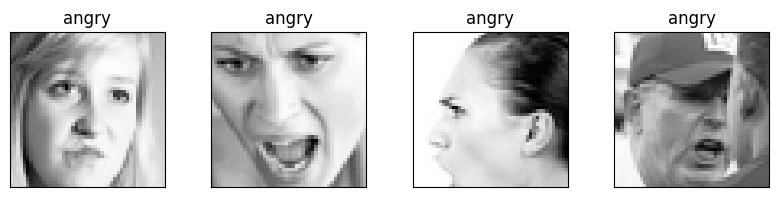

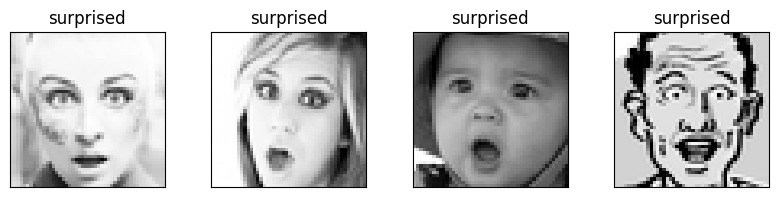

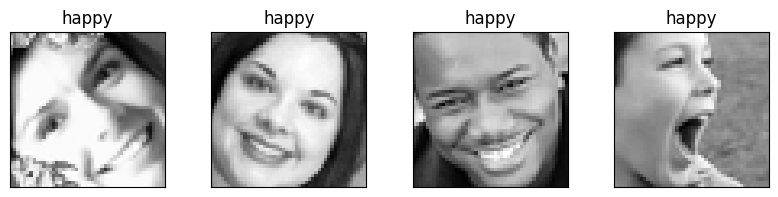

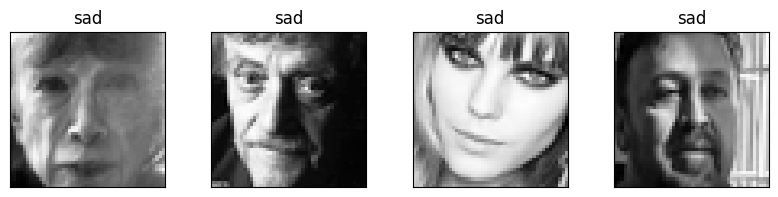

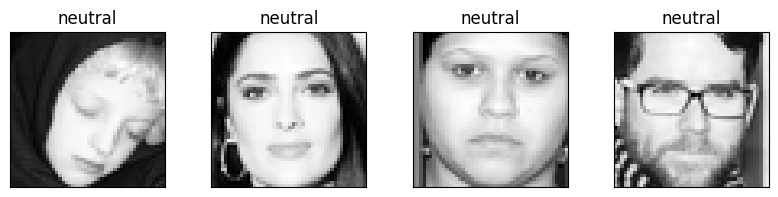

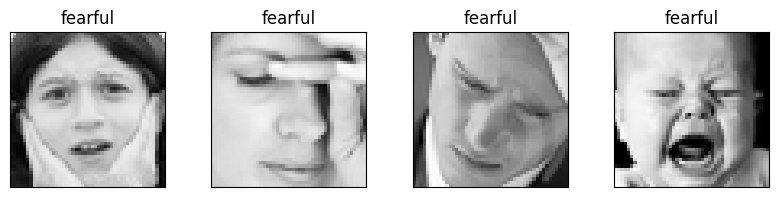

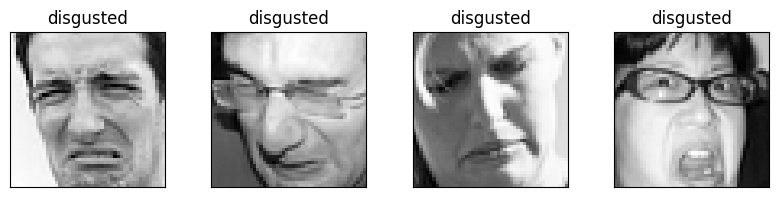

In [11]:
for i in range(len(categories_name_train)):
    plt.figure(figsize=(8,10))
    path = f"./data/train/{categories_name_train[i]}"
    
    for j in range(1,5):
        plt.subplot(3,4,j)
        plt.tight_layout()
        rand_img = Image.open(path +'/'+ np.random.choice(sorted(os.listdir(path))))
        plt.imshow(rand_img, cmap='Greys_r')

        # Don't print the X and Y coordinates on the side of the images.
        plt.xticks([])
        plt.yticks([])
        plt.title(f"{categories_name_train[i]}")

### Test data

Explore the categories available in the testing data.

In [12]:
categories_name_test = os.listdir("./data/test/")
print(f"The categories available are in the test data are: \n   {categories_name_test}")
print(f"The test dataset has {len(categories_name_test)} categories.")

The categories available are in the test data are: 
   ['angry', 'surprised', 'happy', 'sad', 'neutral', 'fearful', 'disgusted']
The test dataset has 7 categories.


Check if the categories categories available in the train are also in test, if not raise an error:

In [13]:
for category in categories_name_train:
    if category not in categories_name_test:
        raise ValueError("The categories available in train doesn't match the test data.")

Check if the number of categories are the same in train and test, if not, raise an error:

In [14]:
if len(categories_name_train) != len(categories_name_test):
    raise ValueError("The lenght of the train and test categories doesn't match.")

Check the categories available in the test dataset.

In [15]:
for i in range(len(categories_name_test)):
    path = f"./data/test/{categories_name_test[i]}"
    print(f"The category {categories_name_test[i]} has {len(os.listdir(path))} images.")

The category angry has 958 images.
The category surprised has 831 images.
The category happy has 1774 images.
The category sad has 1247 images.
The category neutral has 1233 images.
The category fearful has 1024 images.
The category disgusted has 111 images.


Plot 4 random images from each of the categories in the test data

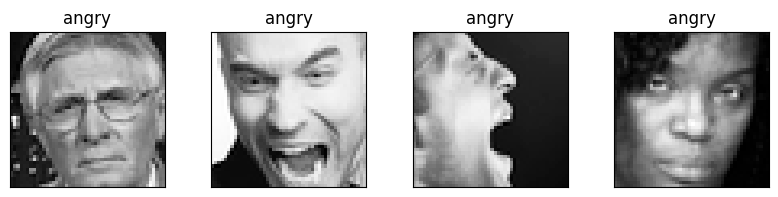

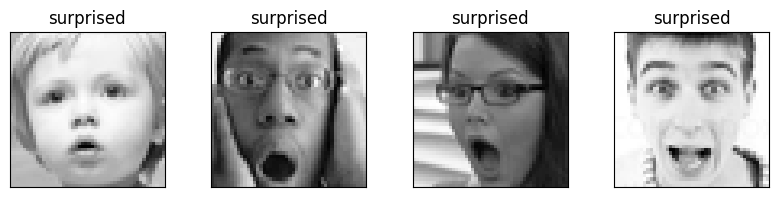

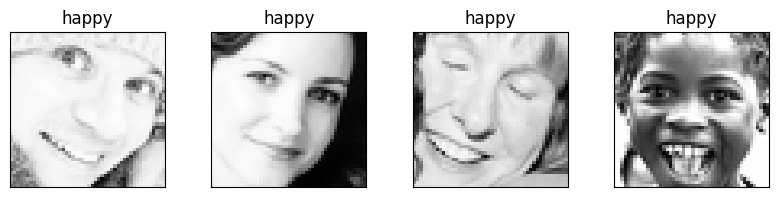

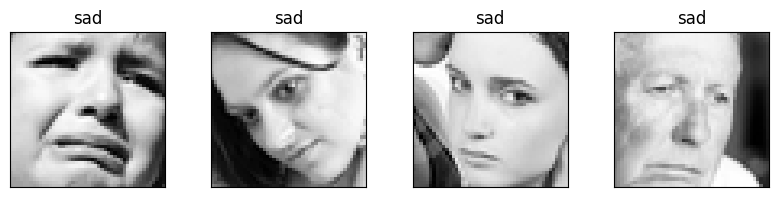

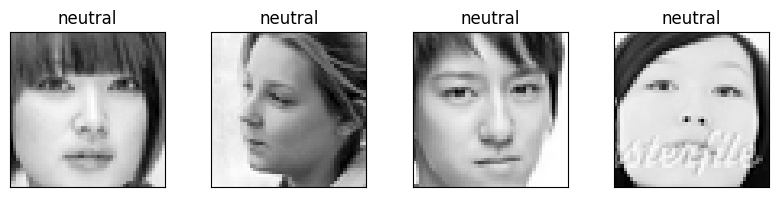

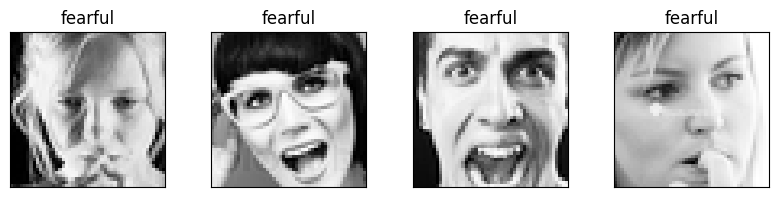

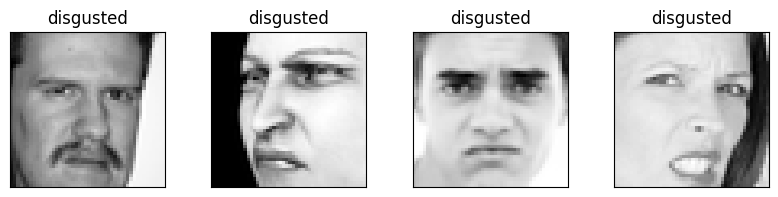

In [16]:
for i in range(len(categories_name_train)):
    plt.figure(figsize=(8,10))
    path = f"./data/train/{categories_name_train[i]}"
    
    for j in range(1,5):
        plt.subplot(3,4,j)
        plt.tight_layout()
        rand_img = Image.open(path +'/'+ np.random.choice(sorted(os.listdir(path))))
        plt.imshow(rand_img, cmap='Greys_r')

        # Don't print the X and Y coordinates on the side of the images.
        plt.xticks([])
        plt.yticks([])
        plt.title(f"{categories_name_train[i]}")

---

## Data transformation

### Create tensorflow dataset

Checking the size of one image

In [17]:
image_path = "./data/train/happy/im0.png"
image = Image.open(image_path)
print(f"Image width: {image.width}.")
print(f"Image height: {image.height}.")

Image width: 48.
Image height: 48.


Check if 10 random images extracted from different categories have the same size, otherwhise raise an error message.

In [18]:
for i in range(10):
    random_category = categories_name_train[np.random.randint(7)]
    cat_path = f"./data/train/{random_category}"
    image_idx = np.random.randint(len(os.listdir(cat_path)))
    image_path = f"./data/train/{random_category}/im{image_idx}.png"
    image = Image.open(image_path)
    if i == 0:
        width = image.width
        height = image.height
    if image.width != width or image.height != height:
        raise ValueError(f"Found an image of diferent size:\n({image.width}X{image.height}) != ({width}X{height})")

print(f"The width of the images is {width}.\nThe height of the images is {height}.")

The width of the images is 48.
The height of the images is 48.


Use the `image_dataset_from_directory()` function to process the images and split the data in `training_dataset` and `validation_dataset`.

Referece: https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image_dataset_from_directory

In [19]:
training_dataset, validation_dataset = tf.keras.preprocessing.image_dataset_from_directory(
                    directory = "./data/train", # path to the main folder
                    labels='inferred',  # infer the labels from the parent directory
                    label_mode='int',   # sparse_categorical_crossentropy loss
                    color_mode='grayscale',
                    image_size=(width, height), # add the size of the images so they're not scaled to 256x256
                    shuffle=True,
                    seed=16,
                    verbose=True,
                    batch_size=8, 
                    validation_split=0.1, # reserve a 10% from the training data for validation
                    subset="both", # returns the validation and train data
                    data_format="channels_last",
)

Found 28709 files belonging to 7 classes.
Using 25839 files for training.
Using 2870 files for validation.


2024-11-12 12:35:25.187213: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Check how many elements have of the training and validation datasets.

In [20]:
print(f"The training dataset has: {len(training_dataset.file_paths)} elements.")
print(f"The validation dataset has: {len(validation_dataset.file_paths)} elements.")

The training dataset has: 25839 elements.
The validation dataset has: 2870 elements.


Check the names of the classes created in train and test are the same

In [21]:
print(f"The validation dataset has these classes:{validation_dataset.class_names}.")
print(f"The training dataset has these classes: {training_dataset.class_names}.")

The validation dataset has these classes:['angry', 'disgusted', 'fearful', 'happy', 'neutral', 'sad', 'surprised'].
The training dataset has these classes: ['angry', 'disgusted', 'fearful', 'happy', 'neutral', 'sad', 'surprised'].


Ensure the batch size has the desired shape

In [22]:
for batch in training_dataset:
    print(batch)
    break

(<tf.Tensor: shape=(8, 48, 48, 1), dtype=float32, numpy=
array([[[[240.],
         [237.],
         [225.],
         ...,
         [243.],
         [243.],
         [244.]],

        [[240.],
         [238.],
         [237.],
         ...,
         [243.],
         [244.],
         [243.]],

        [[240.],
         [240.],
         [240.],
         ...,
         [244.],
         [243.],
         [243.]],

        ...,

        [[221.],
         [219.],
         [219.],
         ...,
         [227.],
         [233.],
         [252.]],

        [[223.],
         [221.],
         [219.],
         ...,
         [233.],
         [251.],
         [255.]],

        [[222.],
         [222.],
         [222.],
         ...,
         [251.],
         [255.],
         [255.]]],


       [[[ 53.],
         [ 40.],
         [ 37.],
         ...,
         [154.],
         [ 75.],
         [ 66.]],

        [[ 40.],
         [ 35.],
         [ 25.],
         ...,
         [ 85.],
         [119.],
  

---

### Normalize the data 

Change the data distribution from (0, 1) to (-1, 1). By using division or multiplication, you'll never get smaller than 0, so the `-1` is needed. 

In [23]:
def normalize_data(image, label):
    image = tf.cast(2*image/255-1, tf.float32)
    return image, label

In [24]:
training_dataset = training_dataset.map(normalize_data)
validation_dataset = validation_dataset.map(normalize_data)

CHeck if the data has been normalized

In [25]:
for batch in training_dataset:
    print(batch)
    break

(<tf.Tensor: shape=(8, 48, 48, 1), dtype=float32, numpy=
array([[[[ 0.49803925],
         [ 0.43529415],
         [ 0.3411765 ],
         ...,
         [ 0.21568632],
         [ 0.24705887],
         [ 0.3176471 ]],

        [[ 0.47450984],
         [ 0.45882356],
         [ 0.37254906],
         ...,
         [ 0.20000005],
         [ 0.2313726 ],
         [ 0.2941177 ]],

        [[ 0.48235297],
         [ 0.47450984],
         [ 0.39607847],
         ...,
         [ 0.10588241],
         [ 0.13725495],
         [ 0.254902  ]],

        ...,

        [[-0.2862745 ],
         [-0.40392154],
         [-0.45098037],
         ...,
         [-0.4980392 ],
         [-0.5372549 ],
         [-0.5921569 ]],

        [[-0.23137254],
         [-0.372549  ],
         [-0.42745095],
         ...,
         [-0.5294118 ],
         [-0.5058824 ],
         [-0.60784316]],

        [[-0.24705881],
         [-0.372549  ],
         [-0.41960782],
         ...,
         [-0.5058824 ],
         [-0.474509

---

### Data augmentation

If needed use ImageDataGenerator to create new images.

In [41]:
# from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [43]:
# training_data_generated = ImageDataGenerator(
#     rotation_range = 20, 
#     width_shift_range = 0.1,
#     height_shift_range = 0.1,
#     fill_mode = "nearest",
#     shear_range = 0.1,
#     zoom_range = 0.2, 
#     horizontal_flip = True
# )

---

## Model

### Dummy classifier

A model that predics always the majority class of the dataset.

In [26]:
def get_class_length(class_name):
    path = f"./data/train/{class_name}"
    return len(os.listdir(path))

In [27]:
all_training_images = 0
max_image_class = 0
for i in range(len(categories_name_train)):
    now_class = get_class_length(categories_name_train[i])
    all_training_images += now_class
    if now_class > max_image_class:
        max_image_class = now_class
    
all_training_images = max_image_class/all_training_images
print(f"The dummy model has an accuracy of:{all_training_images: .2f}%")

The dummy model has an accuracy of: 0.25%


### CNN model

#### Define the model architecture and configuration

Define the architecture of a CNN model with:
- `Conv2D()` layers that will extract features from the image. Link to the reference: https://keras.io/api/layers/convolution_layers/convolution2d/ 
- `Flatten()` layers, `Global Average Pooling` and `Global Max Pooling` can also be used, will transform the output of the convolutional layers into a 1D vector.
- `Dropout()` layers, randomly sets input units to 0 with a frequency of rate at each during the reaining time. https://keras.io/api/layers/regularization_layers/dropout/ 
- `Dense()` layers,  process the extracted features and produce the final predictions.

Link to compile reference: https://keras.io/api/models/model_training_apis/

In [28]:
model = Sequential()

# Add the shape of the input when the model.summary() doesn't work.
model.add(Input(shape=(48, 48, 1))), 

model.add(Conv2D(
    # Output space
    32, 
    kernel_size = 3,

    # Movement of the kernel over the image
    strides = 2,
    
    # Padding = "valid" does not add padding and returns a smaller output, 
    # Padding = "same" adds padding and returns an output of the same size. 
    padding="same",  

    # chanel_last = (height, width, channels) -> usually for TensorFlow / Keras
    # chanel_first =  (channels, height, width)
    # data_format="chanel_last", 

    # Skip pixels when passing with the kernel. 
    # Used when general patterns need to be detected.
    dilation_rate=(1, 1),
    
    # default = 1, if higher the input channels are split and a separate conv operation is performed on each group
    groups=1,

    # relu: hidden layers os CNN -> non-linearity
    # leaky-relu: hidden layers with "dead neurons"
    # softmax: last layer -> multi-class
    # sigmoid: last layer -> binary class
    activation='relu',

    # If True, helps the model learn features more effectively
    # Needs to be False if a BatchNorm layer is added straight after the layer.
    use_bias=True,
    ))


model.add(Conv2D(
    64, 
    kernel_size = 3,
    strides = 2,
    padding="same",
    # data_format="chanel_last", 
    groups=1,
    activation='relu',
    use_bias=True,
    ))

model.add(Conv2D(
    128, 
    kernel_size = 3,
    strides = 2,
    padding="same",
    # data_format="chanel_last", 
    groups=1,
    activation='relu',
    use_bias=True,
    ))

model.add(Flatten()) # Transform the complex multi-dimensional matrix in 1D vector
model.add(Dropout(0.5))
model.add(Dense(7, activation = "softmax")) # Expects a 1D input

In [29]:
# Define the model's configuration
model.compile(
    optimizers.Adam(0.0001),
    loss="sparse_categorical_crossentropy",
    metrics =["accuracy"],
)

Check the summary of the model to understand the number of parameters.

In [30]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 24, 24, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 12, 12, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 6, 6, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 7)              │        32,263 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 124,935 (488.03 KB)

 Trainable params: 124,935 (488.03 KB)

 Non-trainable params: 0 (0.00 B)

Check the input and output shape of each layer of the model

In [31]:
# SVG(model_to_dot(model, show_shapes=True, dpi=72).create(prog='dot', format='svg'))

---

#### Train the model

In [32]:
hist = model.fit(
    training_dataset,
    batch_size=8,
    epochs=120,
    verbose="auto",
    validation_data=validation_dataset,
    shuffle=True, 
)

Epoch 1/120
 777/3230 ━━━━━━━━━━━━━━━━━━━━ 1:24 34ms/step - accuracy: 0.2546 - loss: 1.8260

3230/3230 ━━━━━━━━━━━━━━━━━━━━ 87s 26ms/step - accuracy: 0.2801 - loss: 1.7756 - val_accuracy: 0.3718 - val_loss: 1.6415
Epoch 2/120
3230/3230 ━━━━━━━━━━━━━━━━━━━━ 62s 19ms/step - accuracy: 0.3647 - loss: 1.6330 - val_accuracy: 0.3962 - val_loss: 1.5887
Epoch 3/120
3230/3230 ━━━━━━━━━━━━━━━━━━━━ 54s 17ms/step - accuracy: 0.3918 - loss: 1.5765 - val_accuracy: 0.4073 - val_loss: 1.5552
Epoch 4/120
3230/3230 ━━━━━━━━━━━━━━━━━━━━ 39s 12ms/step - accuracy: 0.4107 - loss: 1.5336 - val_accuracy: 0.4199 - val_loss: 1.5282
Epoch 5/120
3230/3230 ━━━━━━━━━━━━━━━━━━━━ 39s 12ms/step - accuracy: 0.4296 - loss: 1.4976 - val_accuracy: 0.4314 - val_loss: 1.5031
Epoch 6/120
3230/3230 ━━━━━━━━━━━━━━━━━━━━ 39s 12ms/step - accuracy: 0.4400 - loss: 1.4661 - val_accuracy: 0.4418 - val_loss: 1.4808
Epoch 7/120
3230/3230 ━━━━━━━━━━━━━━━━━━━━ 39s 12ms/step - accuracy: 0.4503 - loss: 1.4431 - val_accuracy: 0.4523 - val_loss: 1.4600
Epoch 8/120
3230/3230 ━━━━━━━━━━━━━━━━━━━━ 39s 12ms/step - accuracy: 0.4630 - los

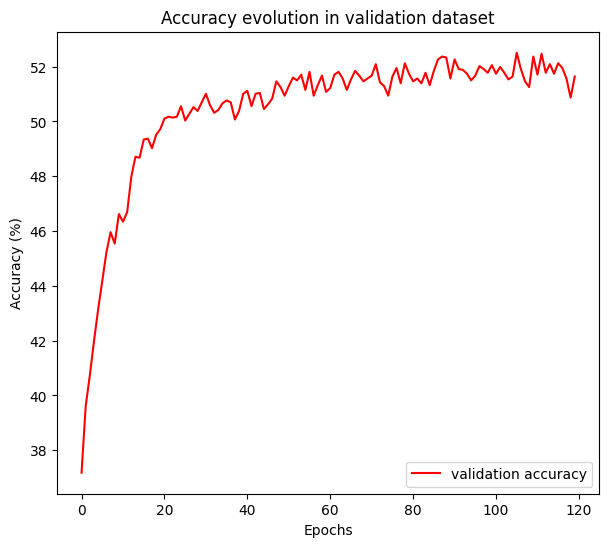

In [37]:
# Plot the accuracy in each epoch for the validation dataset
fig, ax = plt.subplots(1,1, figsize = (7,6))
ax.plot(np.array(hist.history["val_accuracy"])*100, label="validation accuracy", color="red")
ax.set_xlabel("Epochs")
ax.set_ylabel("Accuracy (%)")
ax.set_title("Accuracy evolution in validation dataset")
ax.legend(loc = "lower right")
plt.show()

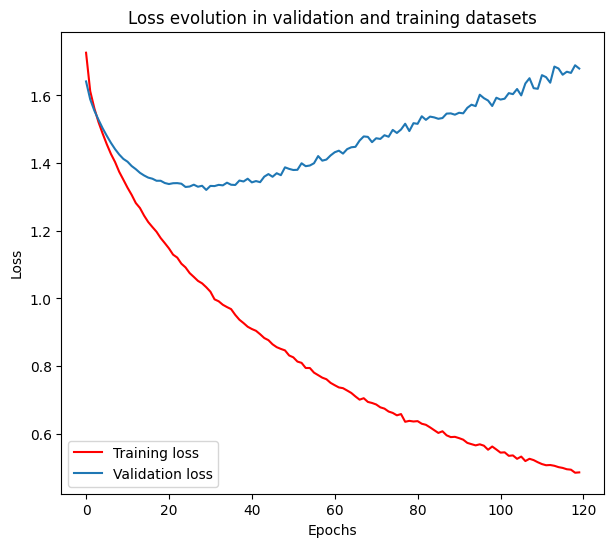

In [38]:
# Plot the Loss in each epoch for the training and validation datasets
fig2, ax = plt.subplots(1,1, figsize = (7,6))
ax.plot(hist.history["loss"], label="Training loss", color = "red")
ax.plot(hist.history["val_loss"], label="Validation loss")
#plt.xlim(0, 10)
#plt.ylim(0, 4)
ax.set_xlabel("Epochs")
ax.set_ylabel("Loss")
ax.set_title("Loss evolution in validation and training datasets")
ax.legend(loc = "lower left")
plt.show()

### Save the data

In [39]:
# Create the dictionary with the model params and the metadata
state_dict = {
            "model_cls": str(model.__class__),
            "params": model.to_json(),
            "metrics":{
                "training_accuracy": hist.history["accuracy"],
                "training_loss": hist.history["loss"],
                "validation_accuracy": hist.history["val_accuracy"],
                "validation_loss": hist.history["val_loss"],
            },
            "meta":{
                "date": datetime.now().isoformat(),
                "student": "Maria Magdalena Balos",
                "course": "DATAMECUM-IA GENERATIVE MASTER",
            },
            }

# Save the json file
dirname = f"{datetime.now().isoformat()}"+"-"+ "CNN"
out_dir = os.path.join(".", "results", dirname)

if not os.path.exists(out_dir):
    os.makedirs(out_dir)
    with open(os.path.join(out_dir, "state_dict.json"), "w") as f:
        json.dump(state_dict,f, indent=4)
    fig.savefig(os.path.join(out_dir, "accuracy_val.pdf"))
    fig2.savefig(os.path.join(out_dir, "loss_train_val.pdf"))


---

#### Evaluation

In [ ]:
# for batch in test_dataset:
    # model.evaluate(batch[0], batch[1])